## This is equal to shortest path crash, but may need to check the class file

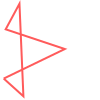

In [1]:
import matplotlib.pyplot as plt
# from matplotlib.patches import Polygon
plt.rcParams["figure.figsize"] = (5,5)
from shapely import Polygon
import numpy as np
np.random.seed(33)

x = [int(np.random.random()*100/2) for i in range(5)]
y = [int(np.random.random()*100/2) for i in range(5)]

ps = zip(x,y)
points = list(ps)

Poly = Polygon(points)
Poly.exterior

[(43, 24), (20, 47), (13, 34), (12, 9), (22, 0)]
LINEARRING (43 24, 20 47, 13 34, 12 9, 22 0, 43 24)
(array('d', [43.0, 20.0, 13.0, 12.0, 22.0, 43.0]), array('d', [24.0, 47.0, 34.0, 9.0, 0.0, 24.0]))


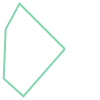

In [2]:
from scipy.spatial import ConvexHull

hull = ConvexHull(points)
hull_points = [points[i] for i in hull.vertices]
inner_points = [point for i, point in enumerate(points) if i not in hull.vertices]
polygon = hull_points + inner_points
print(polygon)
p2 = Polygon(polygon)
Poly = p2
l = Poly.exterior
print(l)
print(l.xy)
p2.exterior

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
{(15.0, 21.0), (26.0, 21.0), (38.0, 23.0), (18.0, 17.0), (15.0, 30.0), (26.0, 30.0), (18.0, 26.0), (26.0, 39.0), (18.0, 35.0), (27.0, 13.0), (29.0, 32.0), (19.0, 9.0), (19.0, 18.0), (21.0, 37.0), (30.0, 18.0), (41.0, 24.0), (33.0, 20.0), (33.0, 29.0), (25.0, 25.0), (25.0, 34.0), (22.0, 10.0), (22.0, 19.0), (34.0, 21.0), (14.0, 15.0), (22.0, 28.0), (34.0, 30.0), (14.0, 24.0), (37.0, 26.0), (22.0, 37.0), (14.0, 33.0), (15.0, 7.0), (26.0, 7.0), (15.

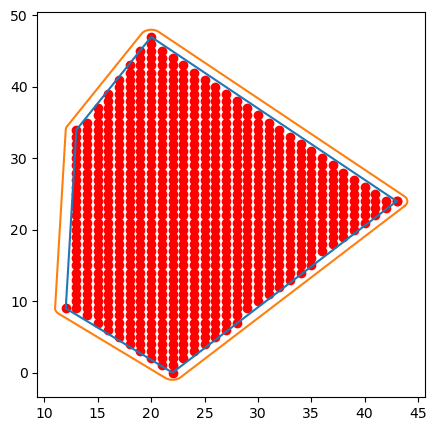

In [3]:
from shapely.geometry import Point

# Polygon exterior points
xp,yp = Poly.exterior.xy

# Gridpoints
xs = np.arange(0, 90, 1)
ys = np.arange(0, 90, 1)

# Inside points
print(xs,ys)
xps, yps = [], []
for xi in xs:
    for yi in ys:
        p = Point(xi,yi)
        if Poly.contains(p):
            xps += [p.x]
            yps += [p.y]
xps += xp
yps += yp

plt.plot(xp,yp)
plt.scatter(xps,yps, color='r')

points = set(list(zip(xps,yps)))
print(points)
print(len(points))
print(len(xps))
print(xp,yp)

buff = Poly.buffer(distance=1)
print(buff)
x1,y1 = buff.exterior.xy
plt.plot(x1,y1)
print("xps, yps", xps,yps)
pol_points = polygon
print(pol_points)

In [4]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame

class ThreeAgentGridworldEnv(gym.Env):
    metadata = {'render_modes': ['human', 'print', 'rgb_array'], "render_fps": 4}    
    def __init__(self, render_mode=None, grid_size=(50, 50), pol_points=pol_points):        
        super(ThreeAgentGridworldEnv, self).__init__()        
        self.Poly = Polygon(pol_points) # Get the points of the polygon
        self.pol_points = pol_points
        self.size = grid_size[0]  # The size of the square grid
        self.window_size = 800  # The size of the PyGame window        
        self.grid_size = grid_size
        # Observation and action space
        self.observation_points = self.obs_points()
        print('Observation points:', self.observation_points)
        self.observation_length = len(self.observation_points)
        self.observation_map = {tuple(self.observation_points[i]):i for i in range(self.observation_length)}
        for p in self.observation_points:
            print('observation map:', p, self.observation_map[tuple(p)])

        self.action_space = spaces.MultiDiscrete([4, 4, 4])  # 4 possible actions for each of the two agents
        self.observation_space = spaces.MultiDiscrete([self.observation_length, self.observation_length, self.observation_length])
        
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

        # Keep track of visited states and count steps
        self.step_count = 0
        self.visited = set()

        # Reset the environment and start
        self.reset()

    def reset(self, seed=None, options={}):
        self.visited = set()
        self.step_count = 0
        self.agent_positions = [
            np.array([30/2, 20/2]),  # Agent 1 
            # np.array([self.grid_size[0]-1, self.grid_size[1]-1]),  # Agent 2 starts at bottom-right corner,
            # np.array([self.grid_size[0]-3, self.grid_size[1]-3])  # Agent 3 starts at specific position,
            np.array([80/2, 50/2]),  # Agent 2 
            np.array([40/2, 80/2]),  # Agent 3 
        ]      
        return self._get_obs()

    def _get_obs(self):
        a1, a2, a3 = self.agent_positions[0], self.agent_positions[1], self.agent_positions[2]
        info = {'agent1': a1, 'agent2': a2, 'agent3': a3, 'step_count': self.step_count}
        p1,p2,p3 = self.observation_map[tuple(a1)], self.observation_map[tuple(a2)], self.observation_map[tuple(a3)]
        return np.array([p1,p2,p3]), info
    
    def obs_points(self):
        xp,yp = Poly.exterior.xy
        # Gridpoints
        xs = np.arange(0, 90, 1)
        ys = np.arange(0, 90, 1)
        # Inside points
        # print(xs,ys)
        xps, yps = [], []
        for xi in xs:
            for yi in ys:
                p = Point(xi,yi)
                if Poly.contains(p):
                    xps += [p.x]
                    yps += [p.y]
        xps += xp
        yps += yp
        # plt.plot(xp,yp)
        # plt.scatter(xps,yps, color='r')
        obs_points = np.array(list(zip(xps,yps)))
        return obs_points

    def step(self, action):
        # Placeholder for terminal state and rewards
        terminated, truncateds = False, False
        rewards = 0
        self.step_count += 1

        # Define the movements corresponding to each action
        movements = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
        
        # Update the positions of both agents
        for i, act in enumerate(action):
            movement = movements[act]
            new_position = self.agent_positions[i] + movement
            
            # Ensure the new position is within bounds
            # new_position = np.clip(new_position, [0, 0], [self.grid_size[0]-1, self.grid_size[1]-1])
            new_p = Point(new_position[0], new_position[1])
            # print("checking new position", tuple(new_position))
            if self.Poly.contains(new_p) or (tuple(new_position) in self.pol_points):
                self.agent_positions[i] = new_position
            if tuple(new_position) in self.visited:
                rewards -= 10
            self.visited.add(tuple(new_position))
        
        
        # If the agents meet at the same position, we can assign a reward or consider it a terminal state
        if np.array_equal(self.agent_positions[0], self.agent_positions[1]) or np.array_equal(self.agent_positions[0], self.agent_positions[2]) or np.array_equal(self.agent_positions[1], self.agent_positions[2]):
            terminated = True
            rewards -= -100  # Example reward for meeting at the same position

        print("step_count:", self.step_count)
        if self.step_count > 20000:
            print("step_count:", self.step_count)
            # truncated = True
    
        # if terminated or truncateds: # play crash music
        #     pygame.mixer.init()
        #     pygame.mixer.music.load('crash.wav')
        #     pygame.mixer.music.play()
        
        
        obs, info = self._get_obs()
        return obs, rewards, terminated, truncateds, info

    def render(self):
        if self.render_mode == 'print':
            grid = np.zeros(self.grid_size)
            grid[tuple(self.agent_positions[0])] = 1  # Mark the position of the first agent
            grid[tuple(self.agent_positions[1])] = 2  # Mark the position of the second agent
            print(grid)
        else:
            if self.window is None and self.render_mode == "human": # Initialize pygame if it is not initialized
                pygame.init()
                pygame.display.init()
                self.window = pygame.display.set_mode(
                    (self.window_size, self.window_size)
                )
            if self.clock is None and self.render_mode == "human":
                self.clock = pygame.time.Clock()
            
            # Fill the canvas
            canvas = pygame.Surface((self.window_size, self.window_size))
            canvas.fill((255, 255, 255))
            pix_square_size = (
                self.window_size / self.size
            )  # The size of a single grid square in pixels

            # Draw the polygon
            pixel_poly_points = [(point[0] * pix_square_size, point[1] * pix_square_size) for point in self.pol_points]
            pygame.draw.polygon(surface=canvas, 
                                color=(255, 255, 0), 
                                points=pixel_poly_points)
            
            # Draw the visited regions
            for p in self.visited:
                pygame.draw.rect(
                canvas,
                pygame.Color(100, 100, 0, a=0.5),
                pygame.Rect(
                    pix_square_size * np.array(p),
                    (pix_square_size, pix_square_size),
                ),
                )


            # agent1 square
            pygame.draw.rect(
                canvas,
                (255, 0, 0),
                pygame.Rect(
                    pix_square_size * self.agent_positions[0],
                    (pix_square_size, pix_square_size),
                ),
            )
            # Now we draw the agent2 circle
            pygame.draw.circle(
                canvas,
                (0, 0, 255),
                (self.agent_positions[1] + 0.5) * pix_square_size,
                pix_square_size / 3,
            )
            # And agent3 circle
            pygame.draw.circle(
                canvas,
                (0, 255, 0),
                (self.agent_positions[2] + 0.5) * pix_square_size,
                pix_square_size / 3,
            )
            
            if self.render_mode == "human":
                # The following line copies our drawings from `canvas` to the visible window
                self.window.blit(canvas, canvas.get_rect())
                pygame.event.pump()
                pygame.display.update()

                # We need to ensure that human-rendering occurs at the predefined framerate.
                # The following line will automatically add a delay to keep the framerate stable.
                self.clock.tick(self.metadata["render_fps"])
                # Finally
                pygame.event.get()

            elif self.render_mode == 'rgb_array':  # rgb_array
                return np.transpose(
                    np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
                )
            
    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [5]:
# Register the environment
gym.envs.registration.register(
    id='ThreeAgentGridworld-v0',
    entry_point=ThreeAgentGridworldEnv,
    max_episode_steps=1000,
)

In [6]:
# Example of creating and using the environment
env = gym.make('ThreeAgentGridworld-v0', render_mode='human')
env.metadata['render_fps'] = 30
obs, info = env.reset()
env.render()

Observation points: [[13.  9.]
 [13. 10.]
 [13. 11.]
 ...
 [12.  9.]
 [22.  0.]
 [43. 24.]]
observation map: [13.  9.] 0
observation map: [13. 10.] 1
observation map: [13. 11.] 2
observation map: [13. 12.] 3
observation map: [13. 13.] 4
observation map: [13. 14.] 5
observation map: [13. 15.] 6
observation map: [13. 16.] 7
observation map: [13. 17.] 8
observation map: [13. 18.] 9
observation map: [13. 19.] 10
observation map: [13. 20.] 11
observation map: [13. 21.] 12
observation map: [13. 22.] 13
observation map: [13. 23.] 14
observation map: [13. 24.] 15
observation map: [13. 25.] 16
observation map: [13. 26.] 17
observation map: [13. 27.] 18
observation map: [13. 28.] 19
observation map: [13. 29.] 20
observation map: [13. 30.] 21
observation map: [13. 31.] 22
observation map: [13. 32.] 23
observation map: [13. 33.] 24
observation map: [14.  8.] 25
observation map: [14.  9.] 26
observation map: [14. 10.] 27
observation map: [14. 11.] 28
observation map: [14. 12.] 29
observation map: [

In [7]:
terminated = False
truncated = False
while True:
    action = env.action_space.sample()
    obs, reward, terminated, truncated,  info = env.step(action)
    env.render()
    print(f"Obs: {obs}, Reward: {reward}, terminated: {terminated}, info: {info}")
    if terminated or truncated:
        print('terminated:', terminated, 'truncated:', truncated)
        break

step_count: 1
Obs: [ 88 796 232], Reward: 0, terminated: False, info: {'agent1': array([16., 10.]), 'agent2': array([39., 25.]), 'agent3': array([19., 40.]), 'step_count': 1}
step_count: 2
Obs: [ 56 803 191], Reward: 0, terminated: False, info: {'agent1': array([15., 10.]), 'agent2': array([40., 25.]), 'agent3': array([18., 40.]), 'step_count': 2}
step_count: 3
Obs: [ 57 804 232], Reward: -10, terminated: False, info: {'agent1': array([15., 11.]), 'agent2': array([40., 26.]), 'agent3': array([19., 40.]), 'step_count': 3}
step_count: 4
Obs: [ 56 804 191], Reward: -20, terminated: False, info: {'agent1': array([15., 10.]), 'agent2': array([40., 26.]), 'agent3': array([18., 40.]), 'step_count': 4}
step_count: 5
Obs: [ 27 803 192], Reward: -10, terminated: False, info: {'agent1': array([14., 10.]), 'agent2': array([40., 25.]), 'agent3': array([18., 41.]), 'step_count': 5}
step_count: 6
Obs: [  1 808 191], Reward: -10, terminated: False, info: {'agent1': array([13., 10.]), 'agent2': array([

KeyboardInterrupt: 

In [ ]:
env.close()

In [ ]:
ssd

In [8]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

In [ ]:
# vec_env = make_vec_env('ThreeAgentGridworld-v0', n_envs=4)

# model = PPO("MlpPolicy", vec_env, verbose=1)
# model.learn(total_timesteps=250000)
# model.save("three_agent_ppo")
# del model

In [9]:
model = PPO.load("three_agent_ppo")
vec_env = make_vec_env('ThreeAgentGridworld-v0', n_envs=1)

c:\Users\jahid\miniconda3\envs\d2lenv\lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(
c:\Users\jahid\miniconda3\envs\d2lenv\lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(


Observation points: [[13.  9.]
 [13. 10.]
 [13. 11.]
 ...
 [12.  9.]
 [22.  0.]
 [43. 24.]]
observation map: [13.  9.] 0
observation map: [13. 10.] 1
observation map: [13. 11.] 2
observation map: [13. 12.] 3
observation map: [13. 13.] 4
observation map: [13. 14.] 5
observation map: [13. 15.] 6
observation map: [13. 16.] 7
observation map: [13. 17.] 8
observation map: [13. 18.] 9
observation map: [13. 19.] 10
observation map: [13. 20.] 11
observation map: [13. 21.] 12
observation map: [13. 22.] 13
observation map: [13. 23.] 14
observation map: [13. 24.] 15
observation map: [13. 25.] 16
observation map: [13. 26.] 17
observation map: [13. 27.] 18
observation map: [13. 28.] 19
observation map: [13. 29.] 20
observation map: [13. 30.] 21
observation map: [13. 31.] 22
observation map: [13. 32.] 23
observation map: [13. 33.] 24
observation map: [14.  8.] 25
observation map: [14.  9.] 26
observation map: [14. 10.] 27
observation map: [14. 11.] 28
observation map: [14. 12.] 29
observation map: [

In [10]:
obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    if dones.any():
        break
    vec_env.render("human")

step_count: 1
step_count: 2
step_count: 3
step_count: 4
step_count: 5
step_count: 6
step_count: 7
step_count: 8
step_count: 9
step_count: 10
step_count: 11
step_count: 12
step_count: 13
step_count: 14
step_count: 15
step_count: 16
step_count: 17
step_count: 18
step_count: 19
step_count: 20
step_count: 21
step_count: 22
step_count: 23
step_count: 24
step_count: 25
step_count: 26
step_count: 27
step_count: 28
step_count: 29
step_count: 30
step_count: 31
step_count: 32
step_count: 33
step_count: 34
step_count: 35
step_count: 36
step_count: 37
step_count: 38
step_count: 39
step_count: 40
step_count: 41
step_count: 42
step_count: 43
step_count: 44
step_count: 45
step_count: 46
step_count: 47
step_count: 48
step_count: 49
step_count: 50
step_count: 51
step_count: 52
step_count: 53
step_count: 54
step_count: 55
step_count: 56
step_count: 57
step_count: 58
step_count: 59
step_count: 60
step_count: 61
step_count: 62
step_count: 63
step_count: 64
step_count: 65
step_count: 66
step_count: 67
step

In [11]:
vec_env.close()